# Coronawiki dataset Analysis

## Setup and libraries

In [2]:
import pandas as pd
%matplotlib inline
import math
import seaborn as sns
import warnings
import numpy as np

from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2


In [3]:
#A voir s'ils nous sont utiles

import sys
import os.path
# Local Modules
from helpers.load import load_interventions, load_aggregated, load_topics, load_pca
from helpers.vars import codes, helper_langs
from helpers.plot import set_size, plot_diffs_in_diffs_interventions, plot_diffs_in_diffs_all
from helpers.diffs_n_diffs import get_diffs_in_diffs_result, get_df_pageviews, get_df_pca
from helpers.diffs_n_diffs import interventions_df_pca, interventions_df_pageviews

   

In [4]:


import os
import gzip
import json
import pickle
import pandas as pd

def load_aggregated(aggregated_path="../data/aggregated.p"):
    if aggregated_path.endswith(".gz"):
        with gzip.open(aggregated_path, "rb") as f:
            agg = json.loads(f.read().decode())
    else:
        with open(aggregated_path, "rb") as f:
            agg = pickle.load(f)

    for k1, i1 in agg.items():
        for k2, i2 in agg[k1].items():
            if type(agg[k1][k2]) == pd.Series:
                agg[k1][k2].index = pd.to_datetime(agg[k1][k2].index, errors="ignore")
            elif (type(agg[k1][k2]) == dict) and len(list(agg[k1][k2].keys())) > 100:
                agg[k1][k2] = pd.Series(agg[k1][k2])
                agg[k1][k2].index = pd.to_datetime(agg[k1][k2].index, errors="ignore")
            elif type(agg[k1][k2]) == dict:
                for k3, i3 in agg[k1][k2].items():
                    if type(agg[k1][k2][k3]) == pd.Series:
                        agg[k1][k2][k3].index = pd.to_datetime(agg[k1][k2][k3].index, errors="ignore")
                    elif (type(agg[k1][k2][k3]) == dict) and len(list(agg[k1][k2][k3].keys())) > 100:
                        agg[k1][k2][k3] = pd.Series(agg[k1][k2][k3])
                        agg[k1][k2][k3].index = pd.to_datetime(agg[k1][k2][k3].index, errors="ignore")
                    elif type(agg[k1][k2][k3]) == dict:
                        for k4, i4 in agg[k1][k2][k3].items():
                            if type(agg[k1][k2][k3][k4]) == pd.Series:
                                agg[k1][k2][k3][k4].index = pd.to_datetime(agg[k1][k2][k3][k4].index, errors="ignore")
                            elif (type(agg[k1][k2][k3][k4]) == dict) and len(list(agg[k1][k2][k3][k4].keys())) > 100:
                                agg[k1][k2][k3][k4] = pd.Series(agg[k1][k2][k3][k4])
                                agg[k1][k2][k3][k4].index = pd.to_datetime(agg[k1][k2][k3][k4].index, errors="ignore")
    return agg


In [5]:
DATA_FOLDER = 'data/'

INTERVENTION_DATASET = DATA_FOLDER+"interventions.csv"
GLOBAL_MOBILITY = DATA_FOLDER+"Global_Mobility_Report.csv.gz"
TIME_SERIE_DATASET = DATA_FOLDER+"aggregated_timeseries.json.gz"
APPLE_MOBILITY = DATA_FOLDER+"applemobilitytrends-2020-04-20.csv.gz"
TOPICS_DATASET=DATA_FOLDER+"topics_linked.csv.xz"

## Apple Mobility preliminary analysis

In [6]:
pip install pycountry-convert

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pycountry_convert as pc
import pycountry

In [8]:
apple_mobility = pd.read_csv(APPLE_MOBILITY,compression='gzip', low_memory=False)
apple_mobility.head(25)

#Correction required for coherence in the table
apple_mobility=apple_mobility.replace('Republic of Korea','South Korea')
apple_mobility=apple_mobility.replace('UK','United Kingdom')
apple_mobility['2020-01-13']=apple_mobility['2020-01-13'].astype('float64')

In [9]:
apple_mobility.describe()

,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
count,395.0,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,...,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,100.0,102.051367,104.575949,107.315089,118.304886,116.855418,96.516025,102.030506,104.140861,105.272911,...,36.836304,32.842278,37.042734,39.554329,41.146304,41.771443,43.430557,40.833139,38.611595,42.489899
std,0.0,4.074084,6.255253,7.713471,13.879839,22.067678,14.519740,9.793529,9.770959,9.003694,...,19.191664,17.313402,17.746450,18.393675,19.500061,19.980858,22.449964,22.565558,20.764037,20.207837
min,100.0,90.140000,73.720000,74.530000,83.960000,69.280000,43.790000,72.900000,69.790000,78.250000,...,4.910000,4.130000,4.470000,6.530000,6.590000,6.790000,6.410000,5.640000,5.210000,6.500000
25%,100.0,99.860000,101.205000,102.705000,108.080000,100.310000,86.675000,97.340000,99.070000,99.900000,...,20.960000,18.410000,22.395000,23.550000,24.125000,24.360000,25.395000,22.400000,21.060000,25.450000
50%,100.0,101.780000,104.190000,106.870000,117.780000,114.840000,97.880000,101.210000,102.930000,104.320000,...,34.530000,31.690000,36.540000,38.910000,39.910000,39.810000,41.460000,38.390000,35.870000,41.000000
75%,100.0,104.045000,107.030000,110.265000,127.260000,129.935000,105.955000,104.810000,107.625000,109.030000,...,49.595000,43.520000,47.865000,52.235000,54.945000,56.915000,57.495000,54.900000,51.435000,57.550000
max,100.0,115.040000,138.000000,139.900000,173.980000,184.300000,157.280000,179.090000,159.860000,150.620000,...,103.790000,87.950000,94.740000,92.090000,94.660000,95.550000,139.080000,134.290000,107.510000,107.600000


In [10]:
# take only countries and regions, not city
apple_mobility_country=apple_mobility[apple_mobility['geo_type']=='country/region']

#find the corresponding continents
listed=apple_mobility_country['region']
continents=[]
for i in range(len(listed)):
    alpha2=pc.country_name_to_country_alpha2(listed[i],cn_name_format="default")
    cont = pc.country_alpha2_to_continent_code(alpha2)
    continents.append(cont)
    
apple_mobility_country['continent']=continents
#put continent as first 4th column
apple_mobility_country.insert(3, 'continent', apple_mobility_country.pop('continent'))
apple_mobility_country.tail()

/tmp/ipykernel_76/3222746322.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_mobility_country['continent']=continents


,geo_type,region,transportation_type,continent,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
148,country/region,United Arab Emirates,walking,AS,100.0,102.29,93.86,108.43,113.32,104.46,...,50.71,56.86,48.50,48.32,43.18,40.57,47.00,51.04,44.18,47.00
149,country/region,Uruguay,driving,SA,100.0,96.84,92.90,103.48,114.91,115.03,...,32.85,24.94,33.68,28.74,33.16,36.07,45.24,38.41,24.94,39.45
150,country/region,Uruguay,walking,SA,100.0,94.90,78.04,100.46,105.04,98.78,...,23.64,14.24,25.57,19.77,23.05,26.22,30.91,26.06,17.38,31.13
151,country/region,Vietnam,driving,AS,100.0,104.96,108.67,107.09,121.07,130.40,...,46.42,45.59,46.78,48.57,54.63,56.93,57.54,58.19,58.25,58.33
152,country/region,Vietnam,walking,AS,100.0,104.44,108.20,107.49,116.63,124.02,...,48.27,46.31,47.65,48.82,53.42,56.38,57.43,58.28,58.35,59.50


In [11]:
#What are the continents represented, and in which proportions ?
apple_mobility_country.groupby('continent').nunique()

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
continent,,,,,,,,,,,,,,,,,,,,,
AF,1,3,2,1,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
AS,1,17,3,1,38,38,38,38,38,38,...,37,38,38,38,38,38,38,38,38,38
EU,1,33,3,1,81,81,80,81,83,83,...,82,81,82,83,83,82,82,83,81,82
NA,1,3,3,1,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
OC,1,2,3,1,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
SA,1,5,3,1,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11


In [12]:
#PLot the different type of mobilities evolution by continents
def plot_mobility(dataset, region):

    transit=dataset[(dataset.transportation_type=="transit") & (dataset.continent==region)]
    driving=dataset[(dataset.transportation_type=="driving") & (dataset.continent==region)]
    walking=dataset[(dataset.transportation_type=="walking") & (dataset.continent==region)]

    fig, axs = plt.subplots(3, sharex=True,figsize=(14,14))
    fig.suptitle('Mobility in ' + region)
    fig.supxlabel("Time (in Days)")
    fig.supylabel("Percent change from baseline")

    if (region != "AF"):  #There is no transit data in Africa and this creates problem with the vline plotting
        transit.loc[:,(transit.dtypes=='float64').values].apply(axs[0].plot,axis=1)
        axs[0].set_title("Transit in " + region)
        axs[0].legend(transit.region, ncol=3)
        axs[0].vlines("2020-03-11",ymin=0,ymax=160)
    
    driving.loc[:,(driving.dtypes=='float64').values].apply(axs[1].plot,axis=1)
    axs[1].set_title("Driving in " + region)
    axs[1].legend(driving.region, ncol=3)
    axs[1].vlines("2020-03-11",ymin=0,ymax=160)

    walking.loc[:,(walking.dtypes=='float64').values].apply(axs[2].plot,axis=1)
    axs[2].set_title("Walking in " + region)
    axs[2].legend(walking.region, ncol=3)
    axs[2].vlines("2020-03-11",ymin=0,ymax=160)
    
    plt.xticks(rotation=90)
    plt.show()


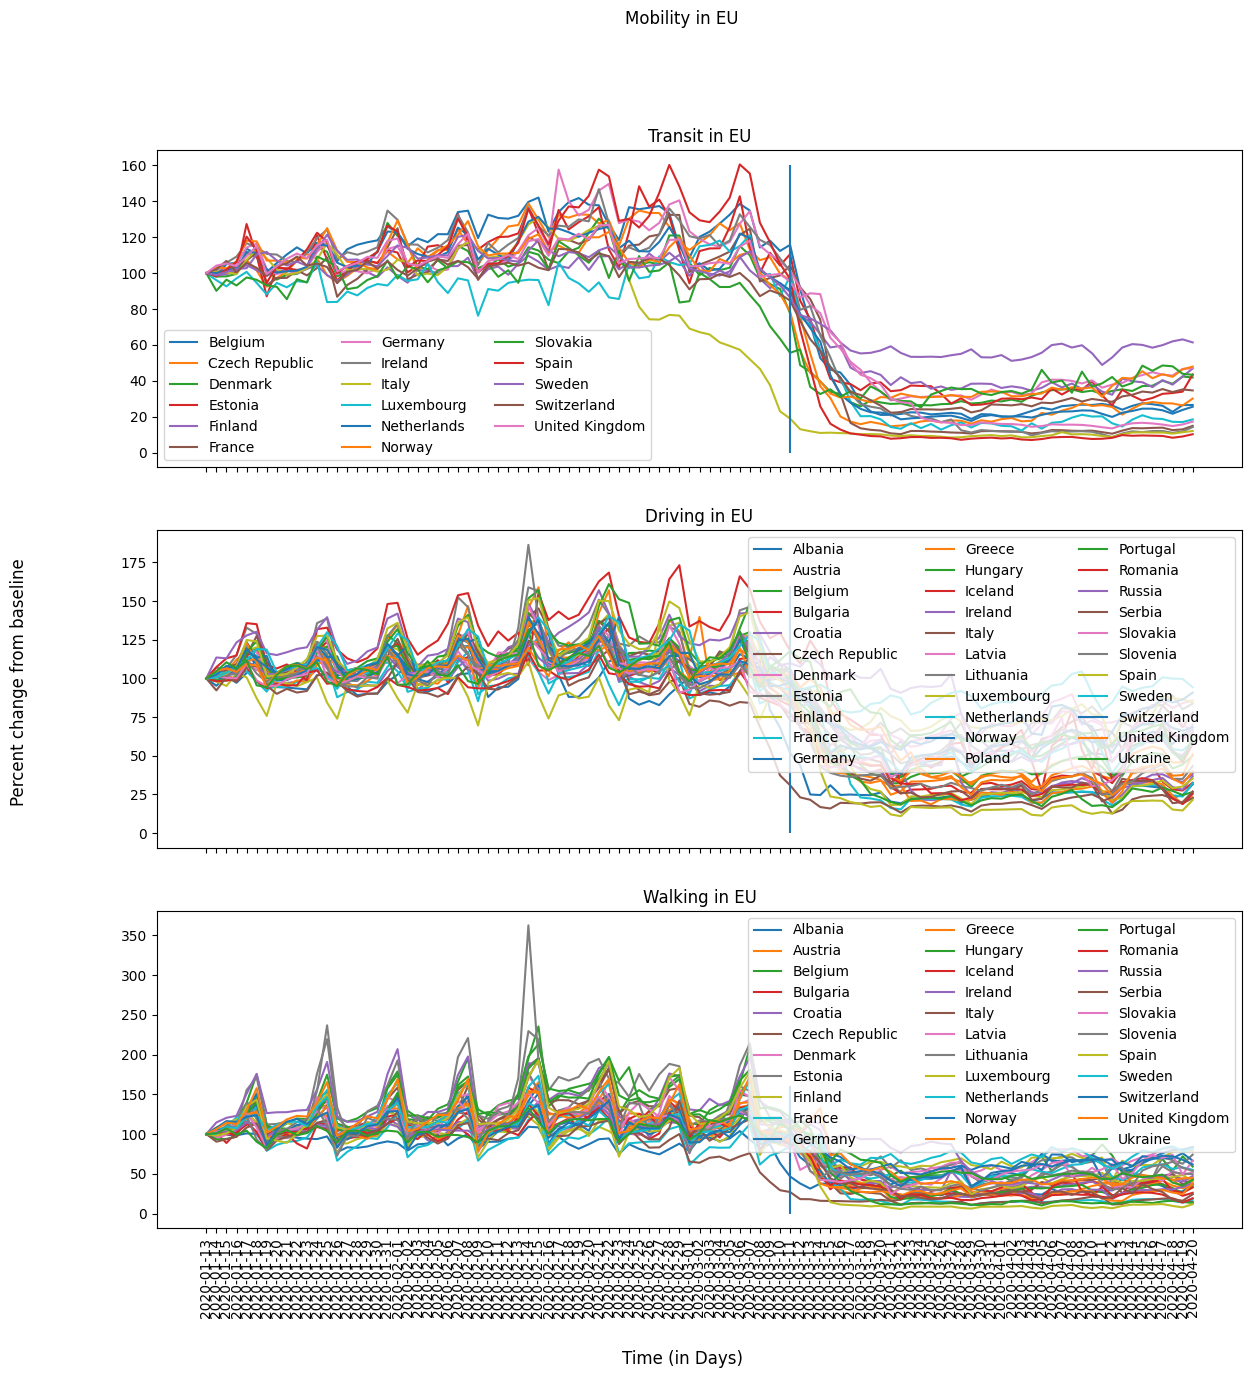

In [13]:
plot_mobility(apple_mobility_country, "EU")

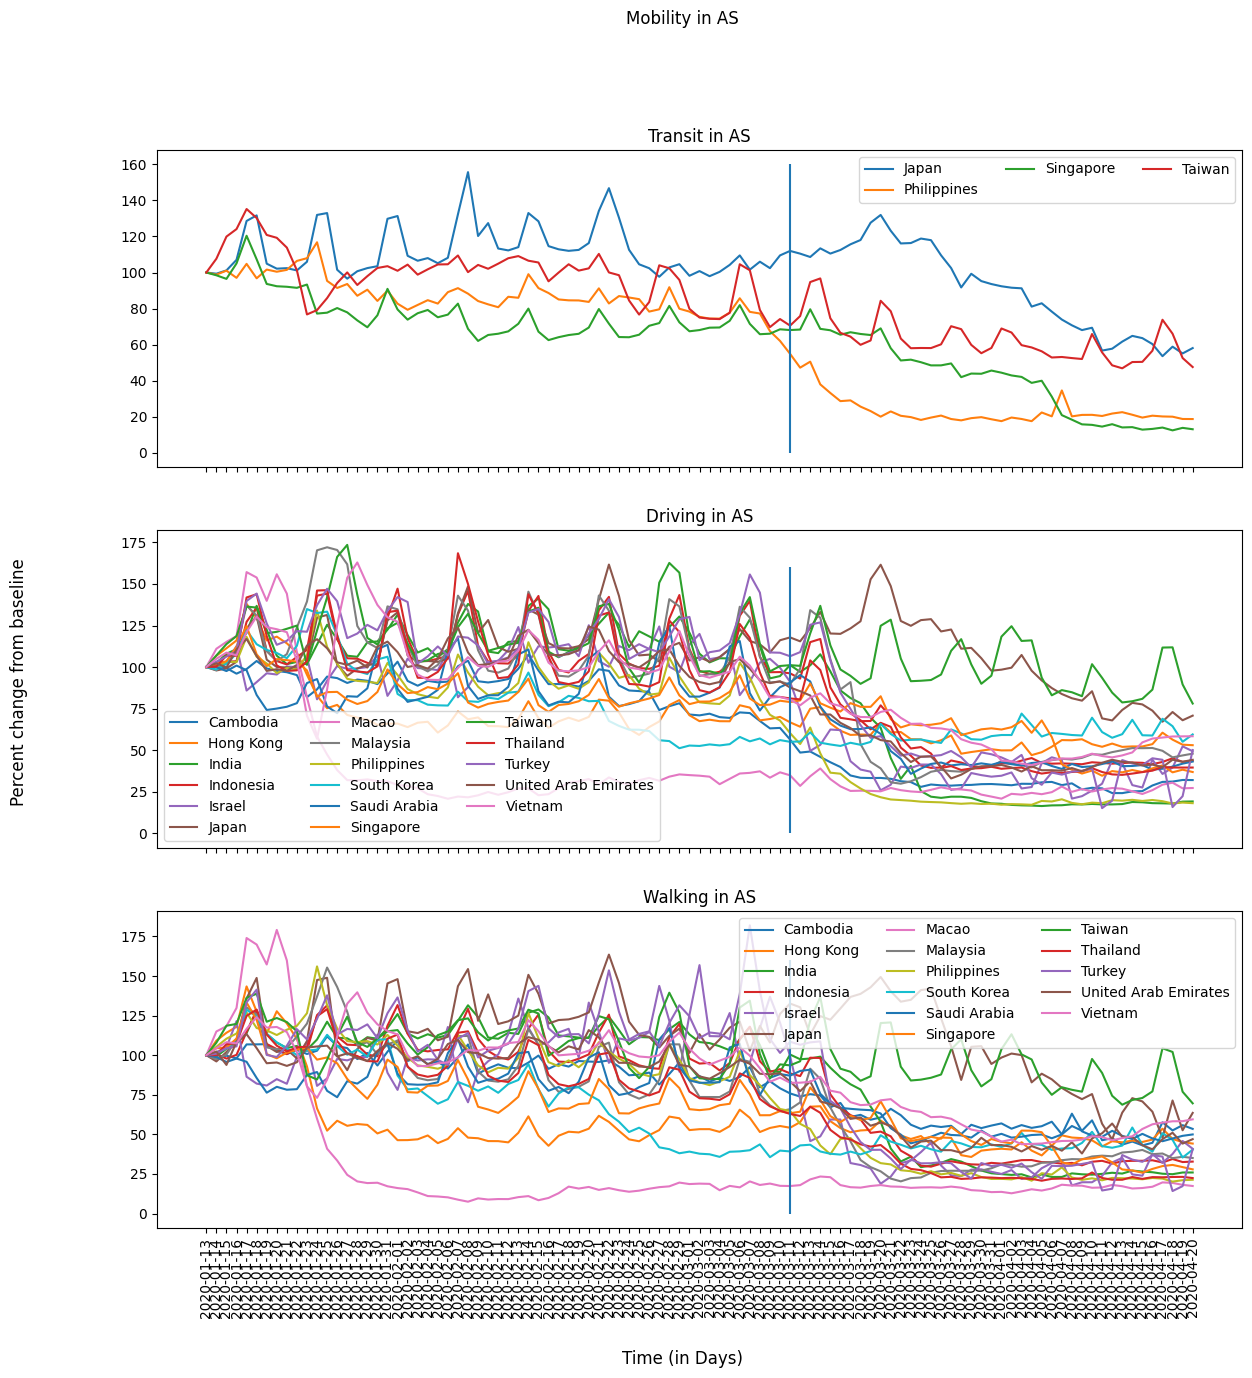

In [14]:
plot_mobility(apple_mobility_country, "AS")

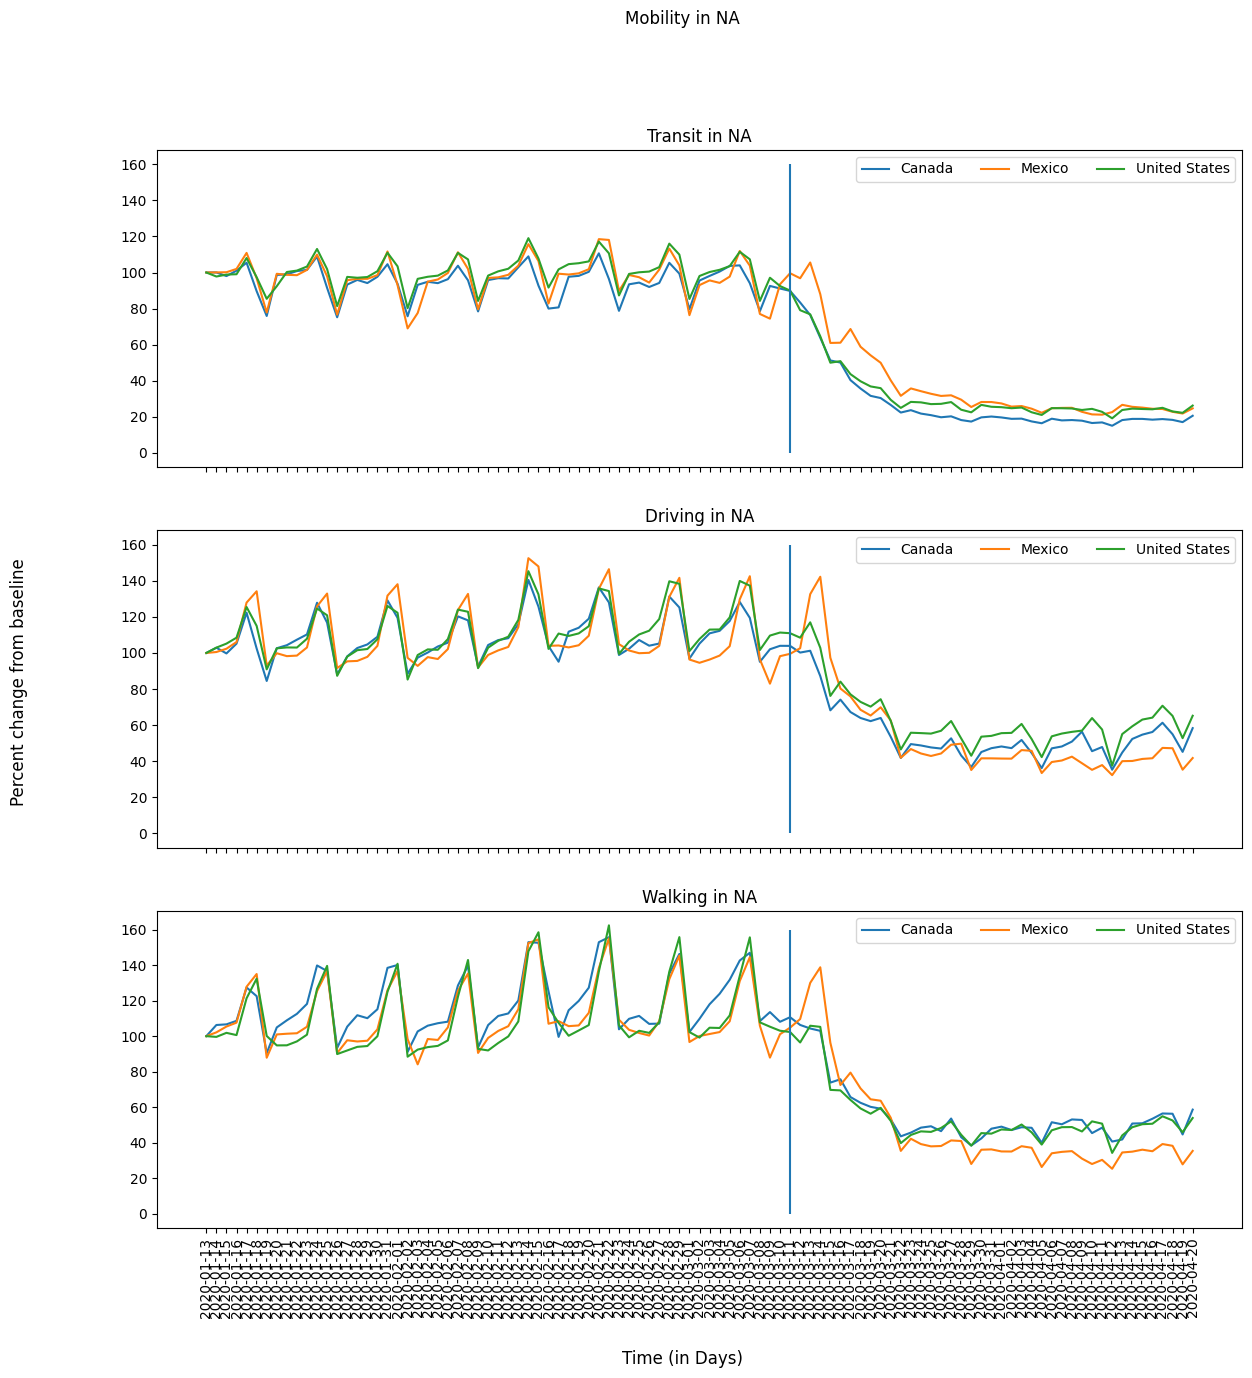

In [15]:
plot_mobility(apple_mobility_country, "NA")


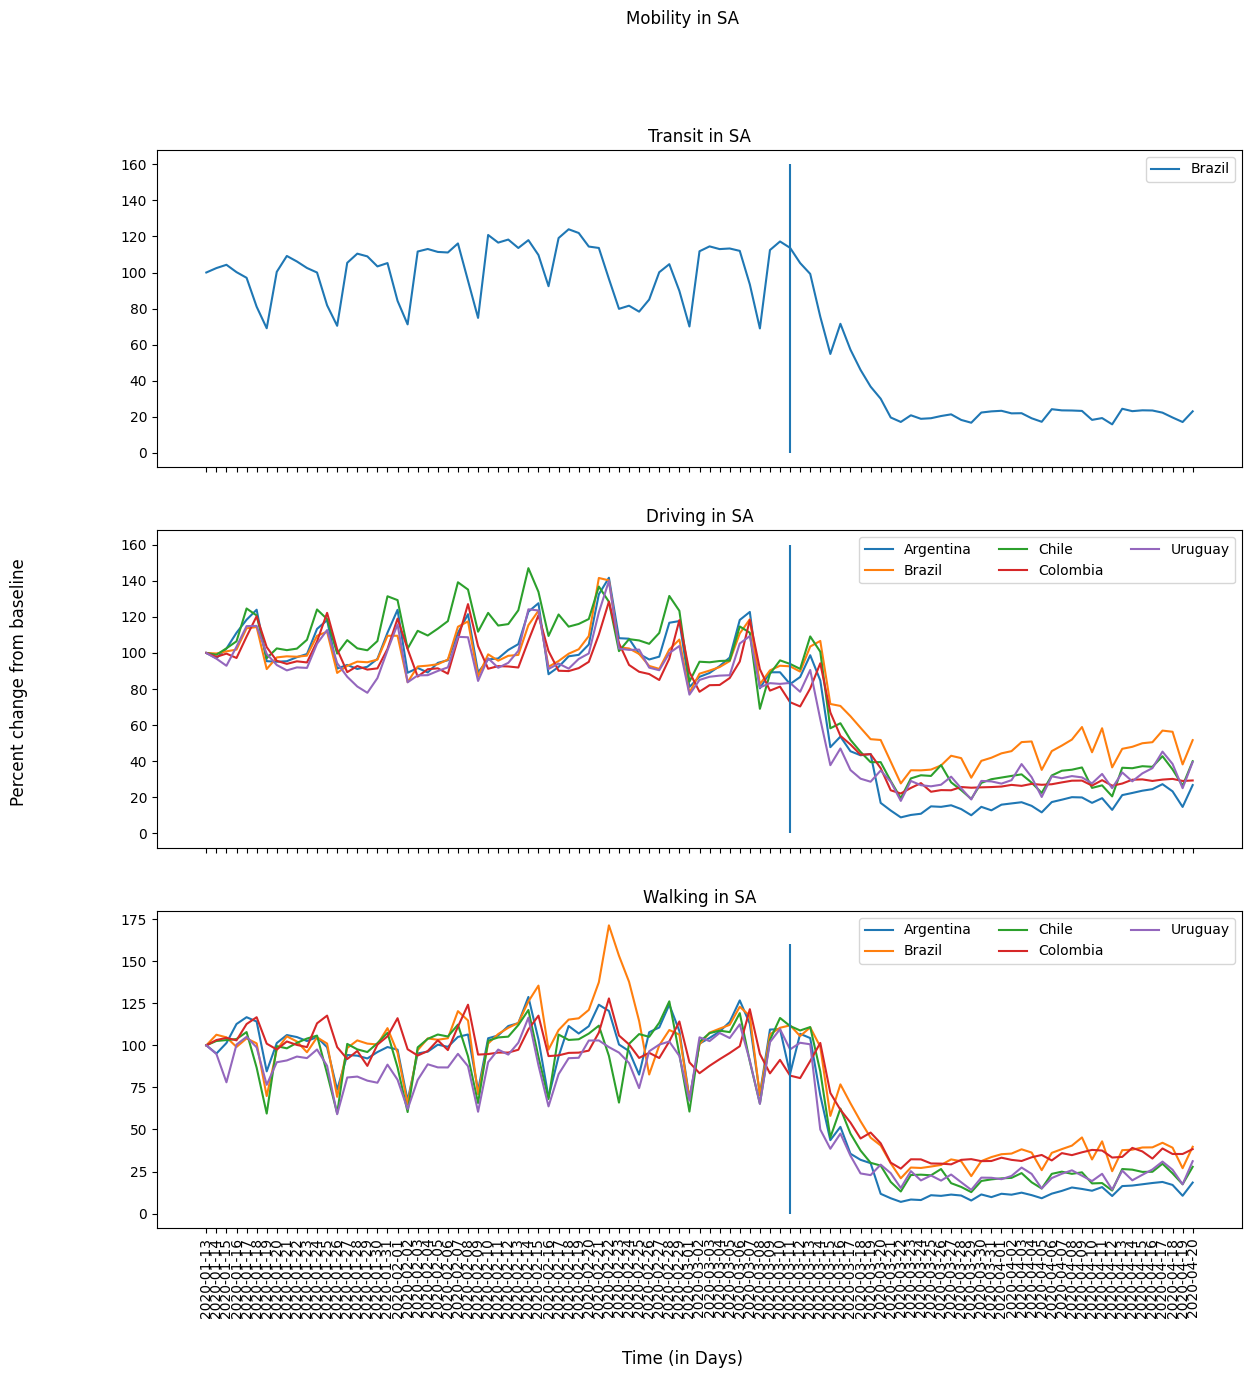

In [16]:
plot_mobility(apple_mobility_country, "SA")

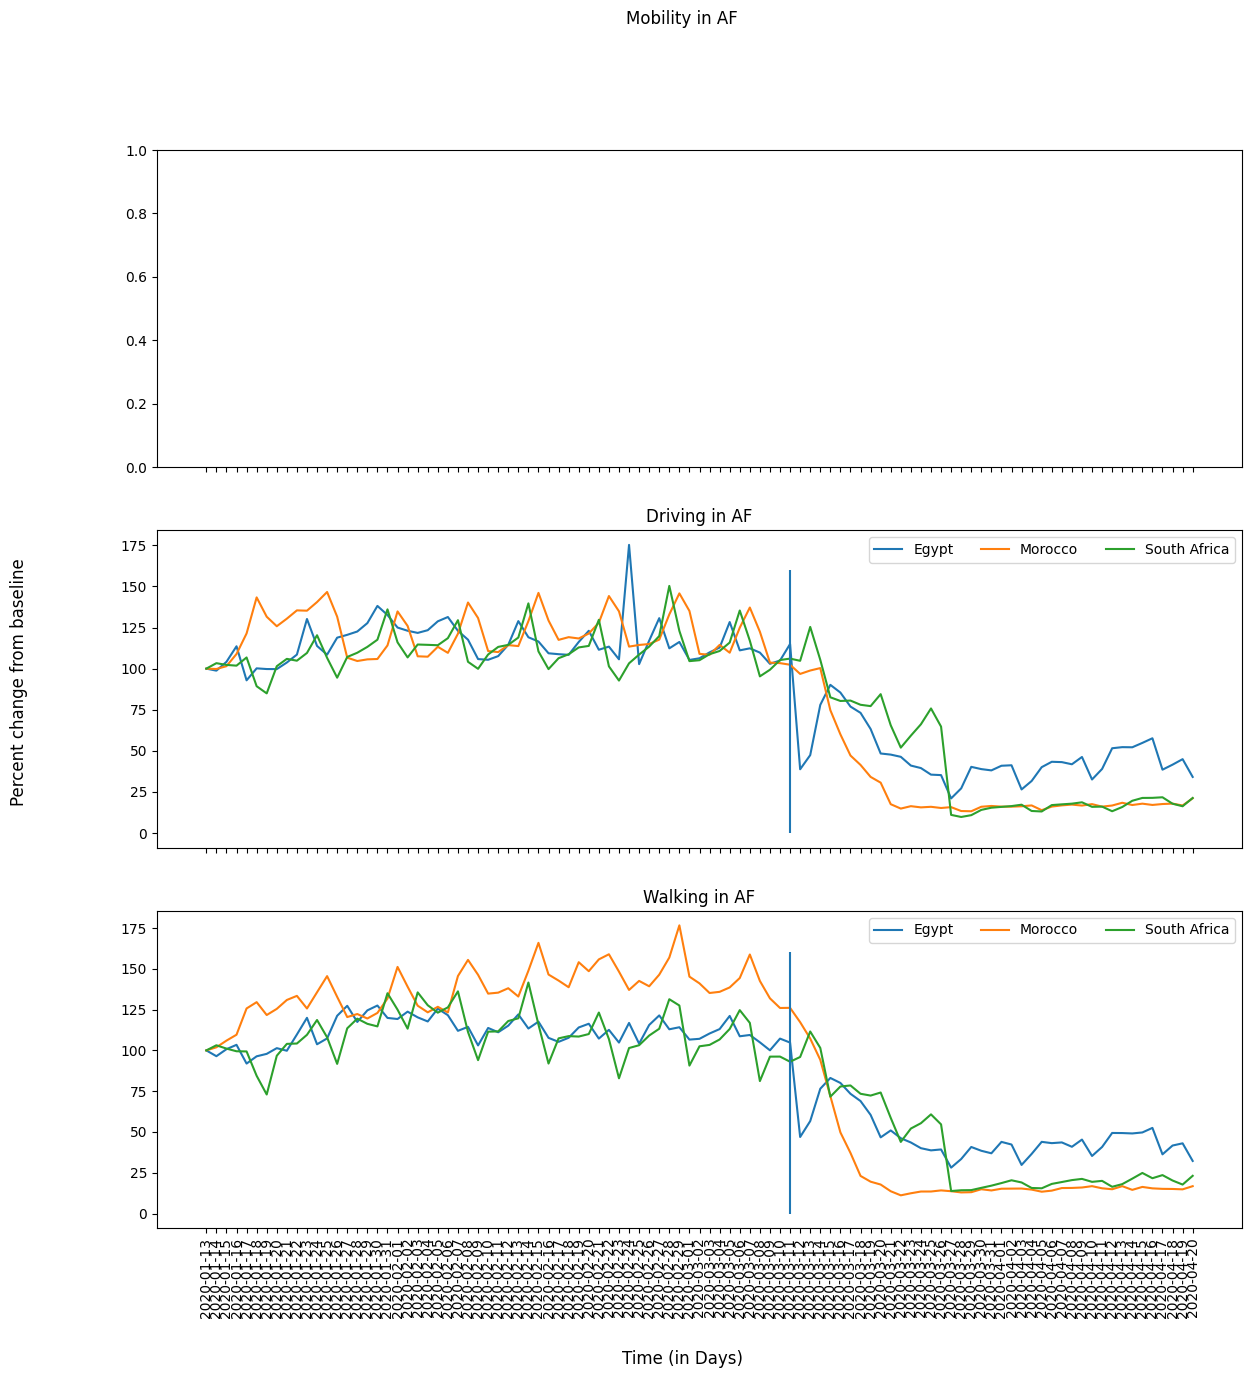

In [17]:
plot_mobility(apple_mobility_country, "AF")

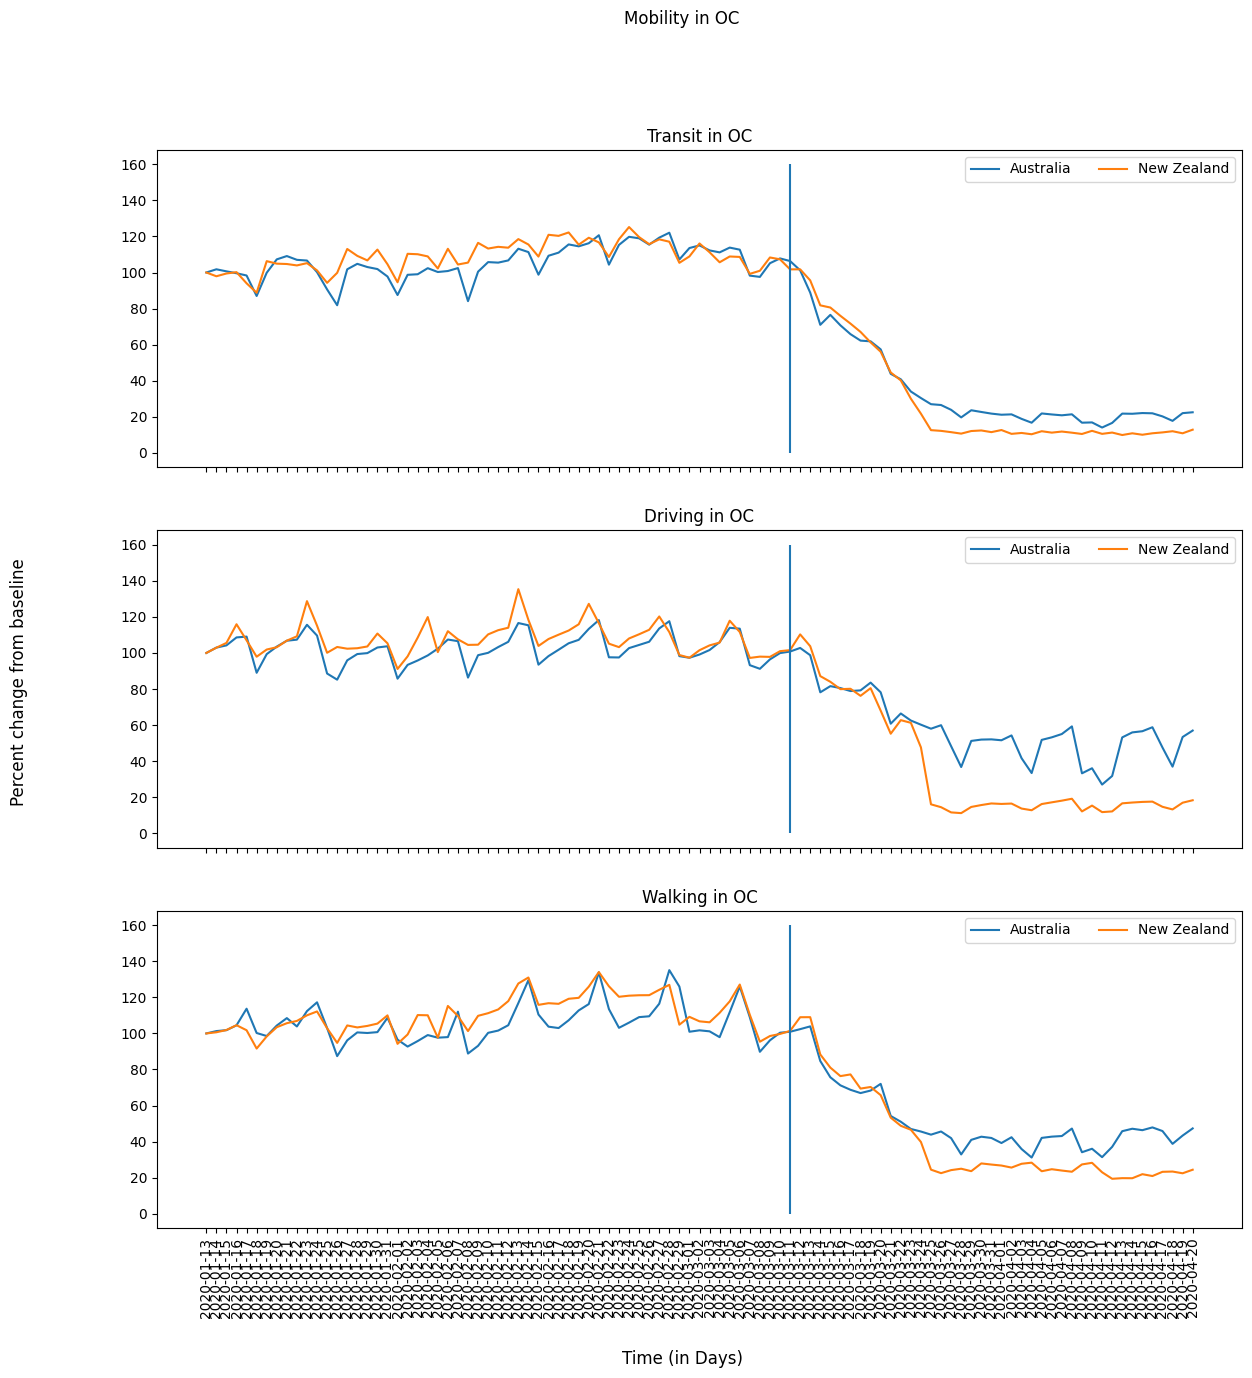

In [18]:
plot_mobility(apple_mobility_country, "OC")

In [19]:
import datetime

def to_day(date):
    #dt = '2020-01-13'
    year, month, day = (int(x) for x in date.split('-'))    
    ans = datetime.date(year, month, day)
    return (ans.strftime("%A"))
to_day('2020-01-13')
day=np.vectorize(to_day)

In [20]:
col_dates=apple_mobility_country.iloc[:,4:].columns
date_df=pd.DataFrame()
date_df['date']=col_dates
date_df['day']=day(col_dates)
date_df

,date,day
0,2020-01-13,Monday
1,2020-01-14,Tuesday
2,2020-01-15,Wednesday
3,2020-01-16,Thursday
4,2020-01-17,Friday
...,...,...
94,2020-04-16,Thursday
95,2020-04-17,Friday
96,2020-04-18,Saturday
97,2020-04-19,Sunday


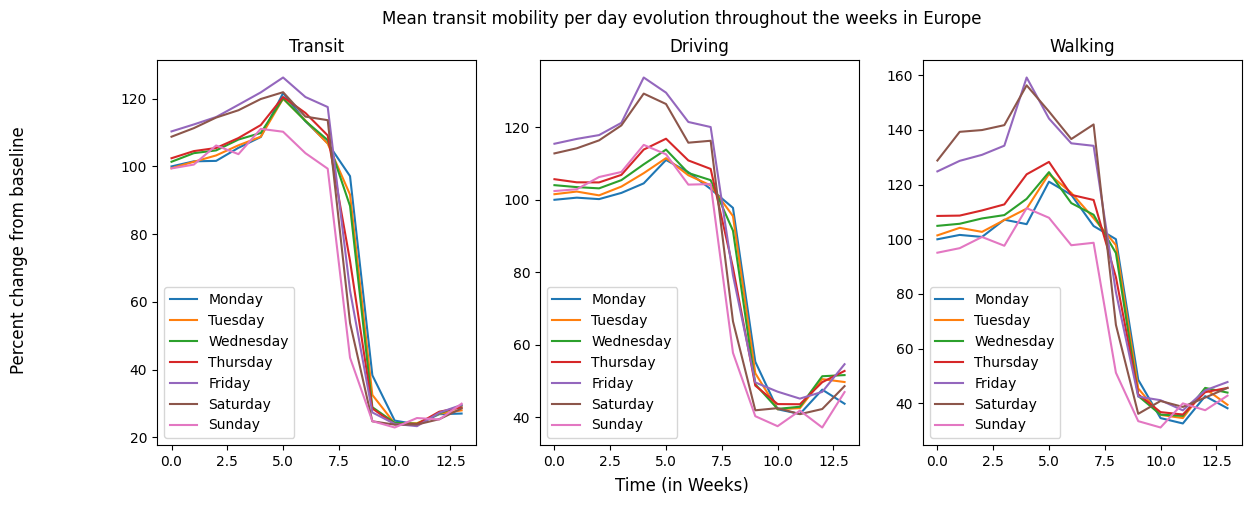

In [21]:
days=['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
fig, axs = plt.subplots(1,3, sharex=True,figsize=(14,5))
fig.supxlabel("Time (in Weeks)")
fig.supylabel("Percent change from baseline")
fig.suptitle("Mean transit mobility per day evolution throughout the weeks in Europe")
 
for day in days:
    days_indf=date_df[date_df.day==day].date
    transit_test=apple_mobility_country[(apple_mobility_country.transportation_type=="transit") & (apple_mobility_country.continent=="EU")]
    transit_test_day=transit_test.loc[:,days_indf]
    default_x_ticks = range(14)
    axs[0].plot(default_x_ticks,transit_test_day.mean()[0:14],label=day)
    axs[0].set_title("Transit")
    axs[0].legend()
    
for day in days:
    days_indf=date_df[date_df.day==day].date
    transit_test=apple_mobility_country[(apple_mobility_country.transportation_type=="driving") & (apple_mobility_country.continent=="EU")]
    transit_test_day=transit_test.loc[:,days_indf]
    default_x_ticks = range(14)
    axs[1].plot(default_x_ticks,transit_test_day.mean()[0:14],label=day)
    axs[1].set_title("Driving")
    axs[1].legend()
    
for day in days:
    days_indf=date_df[date_df.day==day].date
    transit_test=apple_mobility_country[(apple_mobility_country.transportation_type=="walking") & (apple_mobility_country.continent=="EU")]
    transit_test_day=transit_test.loc[:,days_indf]
    default_x_ticks = range(14)
    axs[2].plot(default_x_ticks,transit_test_day.mean()[0:14],label=day)
    axs[2].set_title("Walking")
    axs[2].legend()


# Wikipedia searches primary analysis

In [22]:
def load_interventions(interventions_path='data/interventions.csv'):
    # Loads intervention
    interventions_df = pd.read_csv(interventions_path)
    for col in interventions_df.columns:
        if col != "lang":
            interventions_df.loc[:, col] = pd.to_datetime(interventions_df.loc[:, col])
    interventions = {}
    for _, lang_info in interventions_df.T.to_dict().items():
        lang = lang_info['lang']
        del lang_info['lang']
        interventions[lang] = {k: t for k, t in lang_info.items() if not pd.isnull(t)}
    return interventions

In [23]:
def load_topics(topics_path='data/topics_linked.csv.xz'):
    df_topics = pd.read_csv(topics_path, compression="infer")
    topics = df_topics.columns[1:-1]
    return df_topics, sorted(list(topics))

In [24]:
time_series = load_aggregated("data/aggregated_timeseries.json.gz")
interventions = load_interventions("data/interventions.csv")
topics_df, topics_list = load_topics('data/topics_linked.csv.xz')

In [25]:
list(time_series['ja.m']['topics'])

['Culture.Biography.Biography*',
 'Culture.Biography.Women',
 'Culture.Food and drink',
 'Culture.Internet culture',
 'Culture.Linguistics',
 'Culture.Literature',
 'Culture.Media.Books',
 'Culture.Media.Entertainment',
 'Culture.Media.Films',
 'Culture.Media.Media*',
 'Culture.Media.Music',
 'Culture.Media.Radio',
 'Culture.Media.Software',
 'Culture.Media.Television',
 'Culture.Media.Video games',
 'Culture.Performing arts',
 'Culture.Philosophy and religion',
 'Culture.Sports',
 'Culture.Visual arts.Architecture',
 'Culture.Visual arts.Comics and Anime',
 'Culture.Visual arts.Fashion',
 'Culture.Visual arts.Visual arts*',
 'Geography.Geographical',
 'Geography.Regions.Africa.Africa*',
 'Geography.Regions.Africa.Central Africa',
 'Geography.Regions.Africa.Eastern Africa',
 'Geography.Regions.Africa.Northern Africa',
 'Geography.Regions.Africa.Southern Africa',
 'Geography.Regions.Africa.Western Africa',
 'Geography.Regions.Americas.Central America',
 'Geography.Regions.Americas.North

In [26]:
data = pd.DataFrame.from_dict(time_series)

In [27]:
data.head(5)

,ja.m,it,da.m,tr,no.m,en,sr,tr.m,en.m,no,...,ko.m,fi.m,sr.m,ja,fr,fi,ca,it.m,sv.m,ko
len,1197788,1594039,256451,346007,516838,6047509,632128,345790,6045654,531478,...,489181,480638,396063,1197856,2195949,481854,642031,1588312,1959446,490314
sum,2018-01-01 22328288 2018-01-02 22278953 ...,2018-01-01 3338750 2018-01-02 5428428 20...,2018-01-01 765123 2018-01-02 443384 2018...,2018-01-01 407629 2018-01-02 426791 2018...,2018-01-01 715031 2018-01-02 536506 2018...,2018-01-01 86763830 2018-01-02 11224534...,2018-01-01 192409 2018-01-02 253653 2018...,2018-01-01 493684 2018-01-02 483443 20...,2018-01-01 135822131 2018-01-02 12708735...,2018-01-01 224417 2018-01-02 374771 2018...,...,2018-01-01 1484496 2018-01-02 1248031 20...,2018-01-01 1319053 2018-01-02 1094280 20...,2018-01-01 451383 2018-01-02 462824 2018...,2018-01-01 7828155 2018-01-02 8759385 ...,2018-01-01 6441009 2018-01-02 9079323 ...,2018-01-01 523135 2018-01-02 648344 2018...,2018-01-01 111910 2018-01-02 198405 2018...,2018-01-01 12856884 2018-01-02 12887390 ...,2018-01-01 2383474 2018-01-02 1873096 20...,2018-01-01 819174 2018-01-02 959239 20...
covid,"{'len': 30, 'sum': [55, 55, 51, 46, 70, 77, 73...","{'len': 33, 'sum': [50, 103, 130, 112, 119, 75...","{'len': 4, 'sum': [0, 2, 1, 0, 0, 2, 0, 1, 5, ...","{'len': 64, 'sum': [1, 3, 6, 1, 0, 4, 1, 13, 6...","{'len': 10, 'sum': [7, 5, 2, 2, 2, 0, 3, 2, 7,...","{'len': 306, 'sum': [575, 1081, 1265, 1167, 10...","{'len': 9, 'sum': [6, 13, 11, 6, 13, 6, 11, 9,...","{'len': 64, 'sum': [3, 2, 2, 9, 2, 2, 1, 4, 6,...","{'len': 306, 'sum': [911, 1006, 919, 1026, 978...","{'len': 10, 'sum': [2, 4, 3, 1, 4, 0, 1, 5, 5,...",...,"{'len': 113, 'sum': [6, 5, 8, 8, 10, 2, 7, 7, ...","{'len': 9, 'sum': [0, 0, 8, 0, 0, 2, 0, 3, 1, ...","{'len': 9, 'sum': [11, 20, 15, 30, 33, 17, 31,...","{'len': 30, 'sum': [26, 42, 53, 114, 134, 54, ...","{'len': 16, 'sum': [62, 91, 109, 107, 113, 81,...","{'len': 9, 'sum': [2, 2, 2, 3, 0, 3, 2, 0, 2, ...","{'len': 49, 'sum': [6, 6, 9, 10, 4, 7, 15, 13,...","{'len': 33, 'sum': [139, 187, 162, 180, 127, 1...","{'len': 8, 'sum': [19, 12, 13, 14, 11, 15, 12,...","{'len': 113, 'sum': [3, 20, 20, 16, 20, 8, 1, ..."
topics,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 29427...,{'Culture.Biography.Biography*': {'len': 57720...,{'Culture.Biography.Biography*': {'len': 70443...,{'Culture.Biography.Biography*': {'len': 11603...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 37718...,{'Culture.Biography.Biography*': {'len': 70434...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 11804...,...,{'Culture.Biography.Biography*': {'len': 75406...,{'Culture.Biography.Biography*': {'len': 10422...,{'Culture.Biography.Biography*': {'len': 37580...,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 38258...,{'Culture.Biography.Biography*': {'len': 10444...,{'Culture.Biography.Biography*': {'len': 10175...,{'Culture.Biography.Biography*': {'len': 29422...,{'Culture.Biography.Biography*': {'len': 14668...,{'Culture.Biography.Biography*': {'len': 75498...


In [28]:
ja_m = pd.DataFrame.from_dict(time_series['ja.m']['topics'])

In [29]:
ja_m.head(5)

,Culture.Biography.Biography*,Culture.Biography.Women,Culture.Food and drink,Culture.Internet culture,Culture.Linguistics,Culture.Literature,Culture.Media.Books,Culture.Media.Entertainment,Culture.Media.Films,Culture.Media.Media*,...,STEM.Computing,STEM.Earth and environment,STEM.Engineering,STEM.Libraries & Information,STEM.Mathematics,STEM.Medicine & Health,STEM.Physics,STEM.STEM*,STEM.Space,STEM.Technology
len,149042,22518,5759,10571,6008,24204,3833,6047,20227,93263,...,10688,6338,14036,763,4354,10354,6204,97050,9338,15411
sum,2018-01-01 6629234 2018-01-02 5738239 20...,2018-01-01 1462146 2018-01-02 1192926 20...,2018-01-01 302934 2018-01-02 294667 2018...,2018-01-01 443986 2018-01-02 500888 2018...,2018-01-01 109480 2018-01-02 109097 2018...,2018-01-01 2140880 2018-01-02 2425414 20...,2018-01-01 97435 2018-01-02 121138 2018...,2018-01-01 238059 2018-01-02 269175 2018...,2018-01-01 681533 2018-01-02 854922 20...,2018-01-01 4264889 2018-01-02 3749736 20...,...,2018-01-01 91338 2018-01-02 100635 2018...,2018-01-01 72493 2018-01-02 96614 2018...,2018-01-01 316615 2018-01-02 348167 2018...,2018-01-01 10072 2018-01-02 10519 2018-0...,2018-01-01 44902 2018-01-02 49504 2018-0...,2018-01-01 485801 2018-01-02 550463 2018...,2018-01-01 76863 2018-01-02 84048 2018...,2018-01-01 1793359 2018-01-02 1989455 20...,2018-01-01 64445 2018-01-02 70228 2018-0...,2018-01-01 264636 2018-01-02 289771 2018...
percent,2018-01-01 0.129266 2018-01-02 0.118824 ...,2018-01-01 0.028511 2018-01-02 0.024702 ...,2018-01-01 0.005907 2018-01-02 0.006102 ...,2018-01-01 0.008657 2018-01-02 0.010372 ...,2018-01-01 0.002135 2018-01-02 0.002259 ...,2018-01-01 0.041746 2018-01-02 0.050224 ...,2018-01-01 0.001900 2018-01-02 0.002508 ...,2018-01-01 0.004642 2018-01-02 0.005574 ...,2018-01-01 0.013289 2018-01-02 0.017703 ...,2018-01-01 0.083163 2018-01-02 0.077647 ...,...,2018-01-01 0.001781 2018-01-02 0.002084 ...,2018-01-01 0.001414 2018-01-02 0.002001 ...,2018-01-01 0.006174 2018-01-02 0.007210 ...,2018-01-01 0.000196 2018-01-02 0.000218 ...,2018-01-01 0.000876 2018-01-02 0.001025 ...,2018-01-01 0.009473 2018-01-02 0.011399 ...,2018-01-01 0.001499 2018-01-02 0.001740 ...,2018-01-01 0.034969 2018-01-02 0.041196 ...,2018-01-01 0.001257 2018-01-02 0.001454 ...,2018-01-01 0.005160 2018-01-02 0.006000 ...


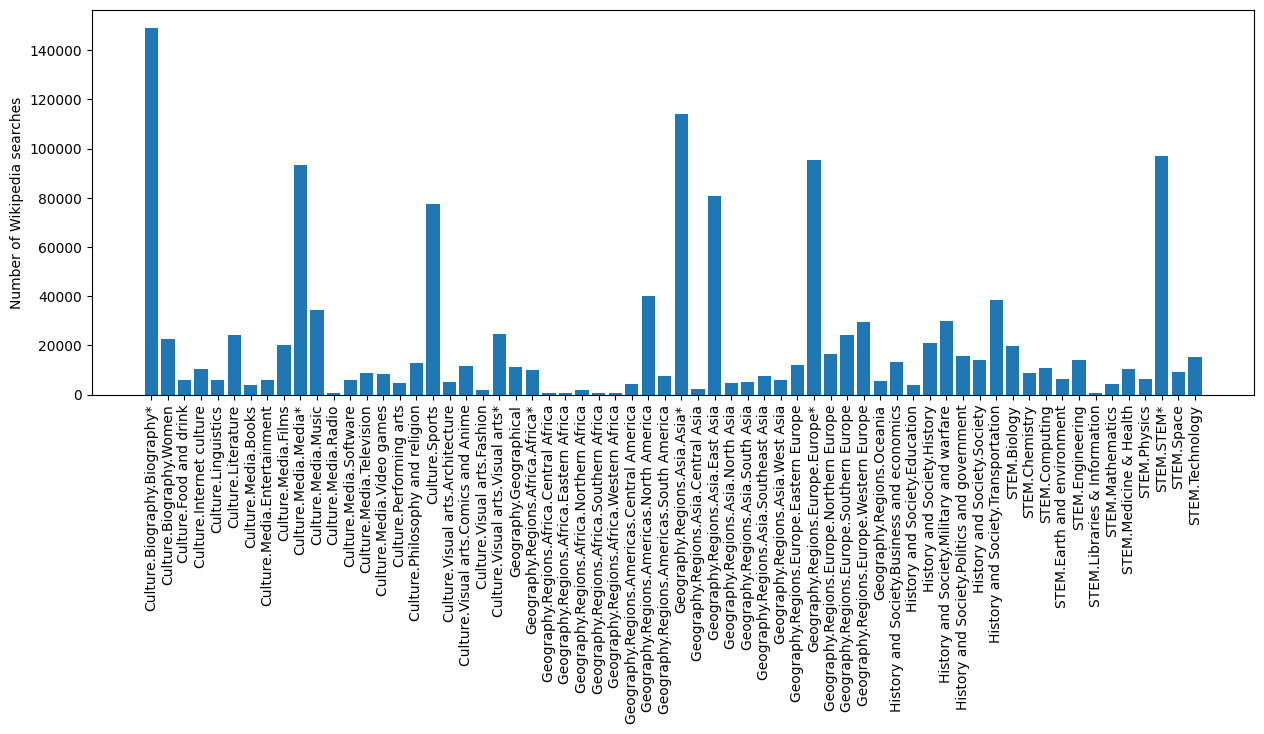

In [32]:
plt.bar(ja_m.loc['len'].index, ja_m.loc['len'][:])
plt.xticks(rotation = 90)
#plt.tick_params(axis='x', which='major', labelsize=3)
plt.rcParams["figure.figsize"] = (25,5)
plt.ylabel('Number of Wikipedia searches')
plt.show()

In [107]:
ja_m_eco = pd.DataFrame.from_dict(time_series['ja.m']['topics']['STEM.Earth and environment'])
ja_eco = pd.DataFrame.from_dict(time_series['ja']['topics']['STEM.Earth and environment'])
JA_eco = pd.concat([ja_m_eco,ja_eco])

events = pd.DataFrame.from_dict(interventions)
japan = events['ja'].dropna()
japan.head()

1st case               2020-01-16
1st death              2020-02-13
School closure         2020-02-27
Public events banned   2020-02-25
Mobility               2020-03-31
Name: ja, dtype: datetime64[ns]

In [67]:
tot = 0
for i in ja_m_eco['sum']:
    tot = tot + i
    
print(tot)

p = 0
for i in ja_eco['sum']:
    p = p + i
    
print(p)

112203289
83098349


In [56]:
ja_m_eco.head(5)

,len,sum,percent
2018-01-01,6338,72493,0.001414
2018-01-02,6338,96614,0.002001
2018-01-03,6338,107578,0.002074
2018-01-04,6338,97229,0.002029
2018-01-05,6338,98070,0.002136


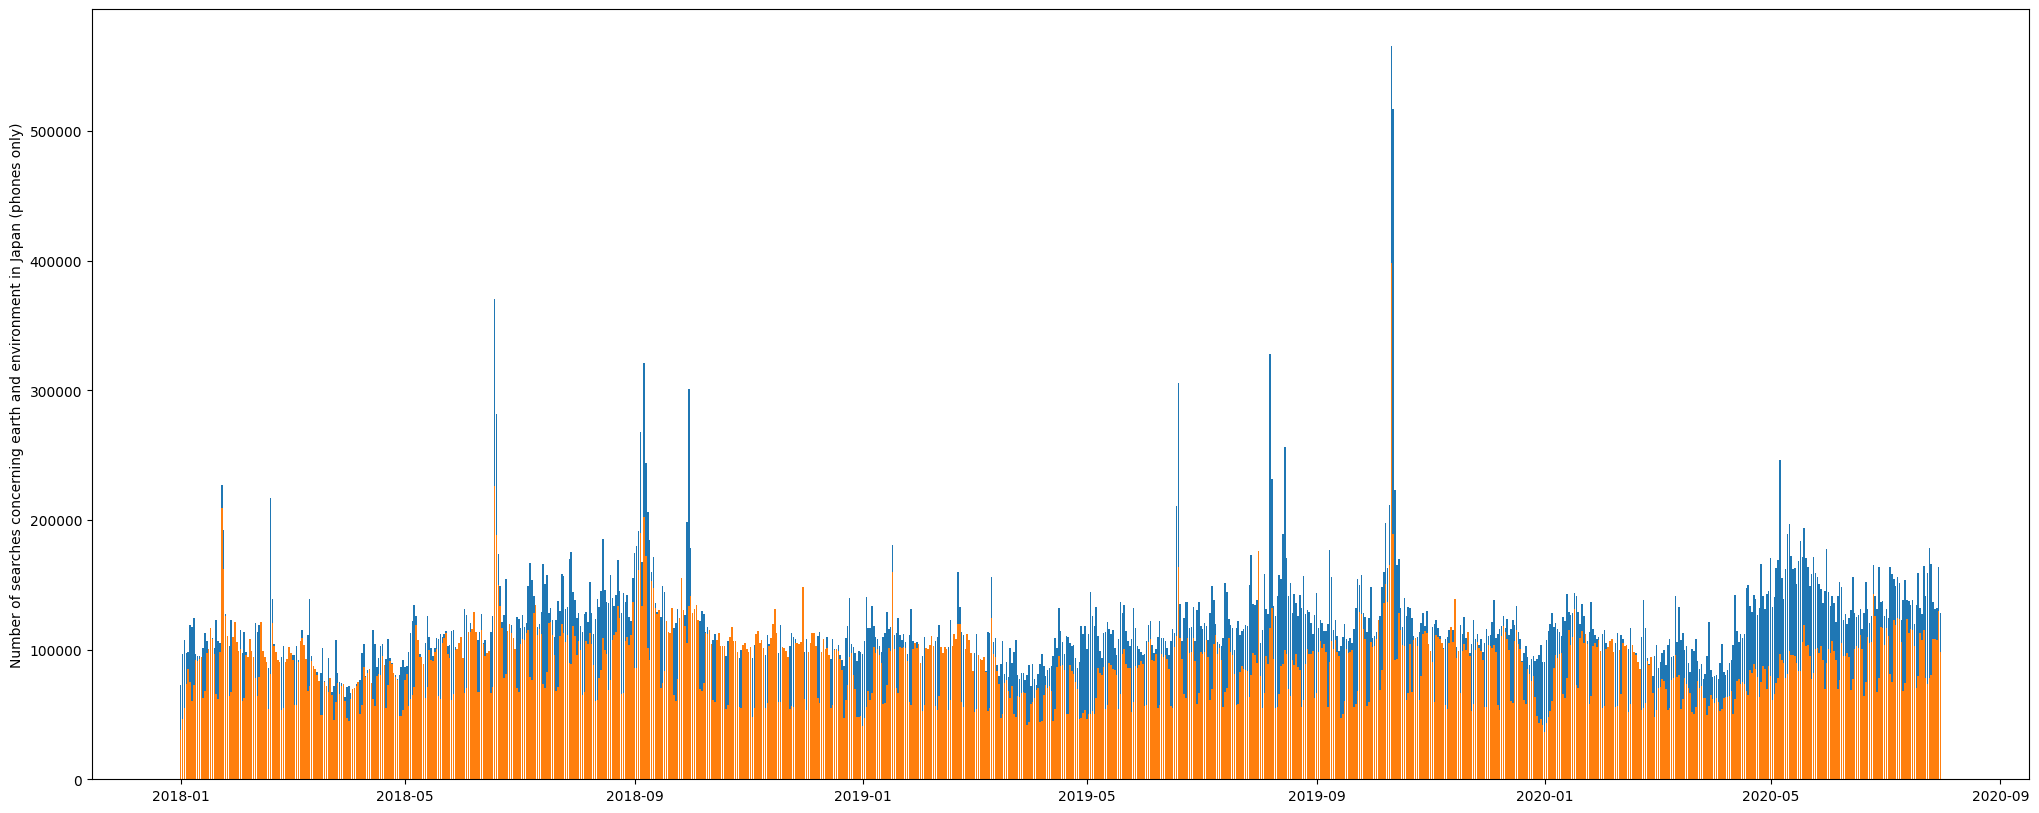

In [68]:
plt.bar(ja_m_eco['sum'].index, ja_m_eco['sum'][:])
plt.bar(ja_eco['sum'].index, ja_eco['sum'][:])
plt.ylabel('Number of searches concerning earth and environment in Japan (phones only)')
plt.rcParams["figure.figsize"] = (25,10)
plt.show()

In [103]:
events["ja"]

1st case               2020-01-16
1st death              2020-02-13
School closure         2020-02-27
Public events banned   2020-02-25
Lockdown                      NaT
Mobility               2020-03-31
Normalcy               2020-06-14
Name: ja, dtype: datetime64[ns]

In [1]:
fig = plt.figure(constrained_layout=False, figsize=(15,20))
gs = fig.add_gridspec(3, 1, hspace=0.4)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

ax1.bar(ja_m_eco['sum'].index, ja_m_eco['sum'][:])
ax1.title('japan data only for phones')
ax2.bar(ja_eco['sum'].index, ja_eco['sum'][:])
ax2.title('japan data only for computer')
ax3.bar(JA_eco['sum'].index, JA_eco['sum'][:])
ax3.title('japan total data')

for i in japan:
    ax3.axvline(i, ls=":", color="black", zorder=1)

NameError: name 'plt' is not defined

In [96]:
events.head(10)

,fr,da,de,it,nl,no,sr,sv,ko,ca,fi,ja,en
1st case,2020-01-24,2020-02-27,2020-01-27,2020-01-31,2020-02-27,2020-02-26,2020-03-06,2020-01-31,2020-01-20,2020-01-31,2020-01-29,2020-01-16,NaT
1st death,2020-02-14,2020-03-12,2020-03-09,2020-02-22,2020-03-06,2020-02-26,2020-03-20,2020-03-11,2020-02-20,2020-02-13,2020-03-21,2020-02-13,NaT
School closure,2020-03-14,2020-03-13,2020-03-14,2020-03-05,2020-03-11,2020-03-13,2020-03-15,2020-03-18,2020-02-23,2020-03-12,2020-03-16,2020-02-27,NaT
Public events banned,2020-03-13,2020-03-12,2020-03-22,2020-03-09,2020-03-24,2020-03-12,2020-03-21,2020-03-12,NaT,2020-03-08,2020-03-16,2020-02-25,NaT
Lockdown,2020-03-17,2020-03-18,2020-03-22,2020-03-11,NaT,2020-03-24,2020-03-21,NaT,NaT,2020-03-14,NaT,NaT,NaT
Mobility,2020-03-16,2020-03-11,2020-03-16,2020-03-11,2020-03-16,2020-03-11,2020-03-16,2020-03-11,2020-02-25,2020-03-16,2020-03-16,2020-03-31,2020-03-16
Normalcy,2020-07-02,2020-06-05,2020-07-10,2020-06-26,2020-05-29,2020-06-04,2020-05-02,2020-06-05,2020-04-15,NaT,2020-05-21,2020-06-14,2020-05-21
